In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Pembacaan File Data Polusi Udara ISPU Excel
DKI1 = pd.read_excel("DATA ISPU - Normalization.xlsx", sheet_name="DKI1")
df = pd.read_excel("DATA ISPU - Normalization.xlsx", sheet_name="DKI1")

# Preprocessing data
DKI1 = DKI1.set_index('Tanggal')

# Splitting data into train and test
train_size = int(0.8 * len(DKI1))
train_data = DKI1.iloc[:train_size]
test_data = DKI1.iloc[train_size:]
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Tanggal   2191 non-null   datetime64[ns]
 1   Wilayah   2191 non-null   object        
 2   PM10      2191 non-null   float64       
 3   SO2       2191 non-null   float64       
 4   CO        2191 non-null   float64       
 5   O3        2191 non-null   float64       
 6   NO2       2191 non-null   float64       
 7   Max       2191 non-null   float64       
 8   Critical  2102 non-null   object        
 9   Kategori  2191 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 171.3+ KB


In [68]:
def mse_function(Y, Y_pred):
    
    M, C = Y.shape[0], Y.shape[1] # Number of examples (M) and number of outputs (C)

    E = Y-Y_pred # Error between Y true and Y predicted
    mse = np.sum(E.T.dot(E))/(M*C) # Mean squared error
    
    return mse

In [69]:
def minmax_normalization(X, a=0, b=1):

    xmin, xmax = X.min(), X.max() # Min and max values of data
    X_norm = a + ( (X-xmin)*(b-a)/(xmax-xmin) ) # Normalized data in a new range

    return X_norm, a, b, xmin, xmax

In [70]:
def apply_minmax_normalization(X, a, b, xmin, xmax):

    X_norm = a + ( (X-xmin)*(b-a)/(xmax-xmin) ) # Normalized data in a new range

    return X_norm

In [71]:
def sliding_window(serie, lag=2, step_forward=1):

    M = len(serie) # Lenght of time series

    X = np.zeros((M-(lag+step_forward-1), lag)) # Input definition
    y = np.zeros((M-(lag+step_forward-1), 1)) # Target definition

    cont = 0
    posinput = lag + cont
    posout = posinput + step_forward

    i = 0
    while posout<=M:

        X[i, :] = serie[cont:posinput]
        y[i] = serie[posout-1]
        cont+=1
        posinput = lag+cont
        posout = posinput + step_forward
        i+=1

    return X, y

In [72]:
def elm_test(X, w1, w2):
    
    M = np.size(X, axis=0) # Number of examples
    N = np.size(X, axis=1) # Number of features

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Xa = np.concatenate((bias, X), axis=1) # Input with bias

    S = Xa.dot(w1.T) # Weighted sum of hidden layer
    H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

    y_pred = Ha.dot(w2.T) # Predictions
    
    return y_pred

In [73]:
def elm_train(X, y, L, w1=None):
    
    M = np.size(X, axis=0) # Number of examples
    N = np.size(X, axis=1) # Number of features
    
    # If w1 is defined
    if w1 is None:
        w1 = np.random.uniform(low=-1, high=1, size=(L, N+1)) # Weights with bias

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Xa = np.concatenate((bias, X), axis=1) # Input with bias

    S = Xa.dot(w1.T) # Weighted sum of hidden layer
    H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

    w2 = (np.linalg.pinv(Ha).dot(y)).T # w2' = pinv(Ha)*D

    y_pred = Ha.dot(w2.T) # Predictions
    
    return y_pred, w1, w2

In [75]:
print(y_test_pred_denorm)

[[0.48676053]
 [0.42475894]
 [0.42451771]
 ...
 [0.33217105]
 [0.36231498]
 [0.50007788]]


In [50]:
print(df.columns)

Index(['Tanggal', 'Wilayah', 'PM10', 'SO2', 'CO', 'O3', 'NO2', 'Max',
       'Critical', 'Kategori'],
      dtype='object')


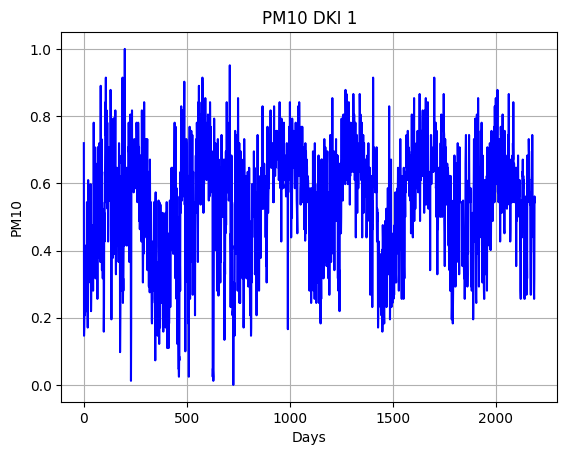

In [51]:
df.PM10.plot(color='blue')

plt.grid()
plt.xlabel('Days')
plt.ylabel('PM10')
plt.title('PM10 DKI 1')

plt.show()

In [52]:
train_size = int(len(df.PM10) * 0.3)

series_train = df.PM10[:train_size].to_numpy()
time_train = df.Tanggal[:train_size].to_numpy()

series_test = df.PM10[train_size:].to_numpy()
time_test = df.Tanggal[train_size:].to_numpy()


In [53]:
series_train_norm, a, b, xmin, xmax = minmax_normalization(series_train, a=0, b=1)
series_test_norm = a+( (series_test-xmin)*(b-a)/(xmax-xmin) )

print('Min value of time series:', series_train.min())
print('Max value of time series:', series_train.max())
print('Min value of normalized time series:', series_train_norm.min())
print('Max value of normalized time series:', series_train_norm.max())

Min value of time series: 0.01219512195122
Max value of time series: 1.0
Min value of normalized time series: 0.0
Max value of normalized time series: 1.0


In [54]:
lag = 2 # Size of lag
step_forward = 1 # Step forward to prediction

print('Number of lags:', lag)
print('Number of step forward:', step_forward)

# Sliding window or lag or lag method
X_train_norm, y_train_norm = sliding_window(series_train_norm, lag, step_forward)
X_test_norm, y_test_norm = sliding_window(series_test_norm, lag, step_forward)

Number of lags: 2
Number of step forward: 1


In [55]:
L = 5 # Number of hidden neurons

print('Number of hidden neuros:', L)

y_train_pred_norm, w1, w2 = elm_train(X_train_norm, y_train_norm, L)
y_test_pred_norm = elm_test(X_test_norm, w1, w2)

Number of hidden neuros: 5


In [56]:
y_train_pred = apply_minmax_normalization(y_train_pred_norm, xmin, xmax, a, b)
y_test_pred = apply_minmax_normalization(y_test_pred_norm, xmin, xmax, a, b)

In [57]:
# Sliding window or lag or lag method
X_train, y_train = sliding_window(series_train, lag, step_forward)
X_test, y_test = sliding_window(series_test, lag, step_forward)

In [58]:
print('Time series:', series_train[0:10])

print('\nInput matrix X:')
print(X_train[0:5])

print('\nTarget variable y:')
print(y_train[0:5])

Time series: [0.7195122  0.14634146 0.17073171 0.24390244 0.30487805 0.20731707
 0.31707317 0.30487805 0.30487805 0.41463415]

Input matrix X:
[[0.7195122  0.14634146]
 [0.14634146 0.17073171]
 [0.17073171 0.24390244]
 [0.24390244 0.30487805]
 [0.30487805 0.20731707]]

Target variable y:
[[0.17073171]
 [0.24390244]
 [0.30487805]
 [0.20731707]
 [0.31707317]]


In [59]:
train_mse = mse_function(y_train, y_train_pred)
test_mse = mse_function(y_test, y_test_pred)

print('Training MSE:', train_mse)
print('Testing MSE:', test_mse)

Training MSE: 0.021063498590749734
Testing MSE: 0.013424934878744358


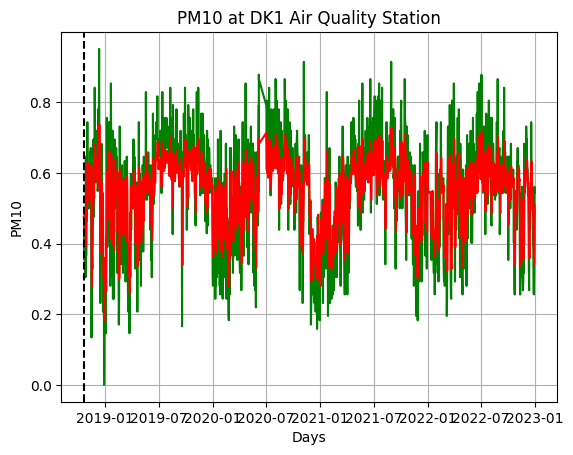

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Menghitung selisih waktu antara time_train[-1] dan time_test[0]
time_diff = np.timedelta64(time_test[0] - time_train[-1]).astype('int64')

# Menghitung titik tengah antara time_train[-1] dan time_test[0]
point = time_train[-1] + np.timedelta64(time_diff // 2, 'ns')

plt.plot(time_test, series_test, 'g')
plt.plot(time_test[lag:], y_test_pred, 'r')
plt.axvline(point, color='k', linestyle='--')

plt.grid()
plt.xlabel('Days')
plt.ylabel('PM10')
plt.title('PM10 at DK1 Air Quality Station')

plt.show()


In [61]:

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score



train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test[:len(y_test_pred)], y_test_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
train_mse = mse_function(y_train, y_train_pred)
test_mse = mse_function(y_test, y_test_pred)






print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("\n")
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("\n")
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)
print("\n")
print('Training MSE:', train_mse)
print('Testing MSE:', test_mse)


Train RMSE: 0.14513269304588036
Test RMSE: 0.11586602124326335


Train MAE: 0.11385720772400318
Test MAE: 0.0888906482418799


Train R^2: 0.4022610154887718
Test R^2: 0.4111631856212705


Training MSE: 0.021063498590749734
Testing MSE: 0.013424934878744358


In [62]:
print(len(time_train))
print(len(y_test_pred))

657
1532


In [63]:
# Menampilkan min dan max partikel
min_par = DKI1['PM10'].min()
max_par = DKI1['PM10'].max()

# Denormalize
max_value = 100.0
min_value = 0.0

print("Nilai maksimum Partikel :", max_par)
print("Nilai minimum Partikel :", min_par)

test_Y_denorm = (y_test.flatten() * (max_value - min_value) + min_value)
prediksi_denorm = (y_test_pred.flatten() * (max_value - min_value) + min_value)


Nilai maksimum Partikel : 1.0
Nilai minimum Partikel : 0.0


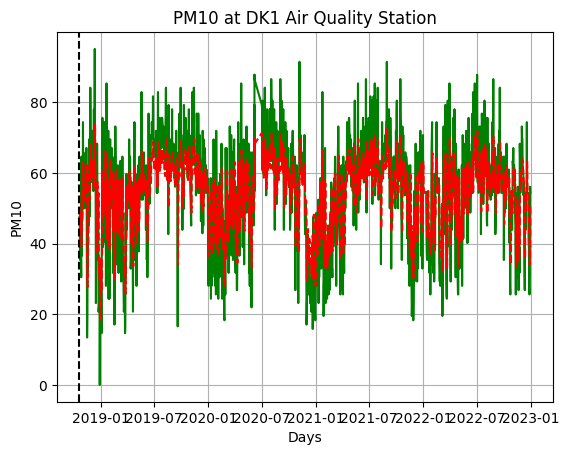

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Menghitung selisih waktu antara time_train[-1] dan time_test[0]
time_diff = np.timedelta64(time_test[0] - time_train[-1]).astype('int64')

# Menghitung titik tengah antara time_train[-1] dan time_test[0]
point = time_train[-1] + np.timedelta64(time_diff // 2, 'ns')

series_train_denorm = (series_train.flatten() * (max_value - min_value) + min_value)
series_test_denorm = (series_test.flatten() * (max_value - min_value) + min_value)
prediksi_denorm = (y_test_pred.flatten() * (max_value - min_value) + min_value)

plt.plot(time_test, series_test_denorm, 'g')
plt.plot(time_test[lag:], prediksi_denorm, 'r--')
plt.axvline(point, color='k', linestyle='--')

plt.grid()
plt.xlabel('Days')
plt.ylabel('PM10')
plt.title('PM10 at DK1 Air Quality Station')

plt.show()


In [65]:
# Adjust the length of series_test_denorm and prediksi_denorm to match time_test
series_test_denorm = series_test_denorm[:len(time_test)-lag]
prediksi_denorm = prediksi_denorm[:len(time_test)-lag]

# Create a DataFrame to store the forecast results
forecast_df = pd.DataFrame({
    'Tanggal': pd.to_datetime(time_test[lag:]),
    'PM10_actual': series_test_denorm.flatten(),
    'PM10_prediksi': prediksi_denorm.flatten()
})

# Set the option to display all rows in the DataFrame
pd.set_option('display.max_rows', None)

# Print the forecast DataFrame
print(forecast_df)


        Tanggal  PM10_actual  PM10_prediksi
0    2018-10-22    47.560976      49.473678
1    2018-10-23    46.341463      43.318686
2    2018-10-24    35.365854      43.283236
3    2018-10-25    39.024390      48.472593
4    2018-10-26    47.560976      45.560901
5    2018-10-27    39.024390      39.225808
6    2018-10-28    30.487805      53.919886
7    2018-10-29    64.634146      46.296052
8    2018-10-30    36.585366      47.346826
9    2018-10-31    46.341463      51.717550
10   2018-11-01    51.219512      53.164606
11   2018-11-02    52.439024      62.910526
12   2018-11-03    74.390244      54.288556
13   2018-11-04    50.000000      55.291502
14   2018-11-05    57.317073      52.831303
15   2018-11-06    50.000000      53.556063
16   2018-11-07    53.658537      52.323100
17   2018-11-08    50.000000      56.407982
18   2018-11-09    59.756098      55.601705
19   2018-11-10    54.878049      54.690906
20   2018-11-11    54.384645      59.867662
21   2018-11-12    65.853659    

In [66]:
# Menyimpan DataFrame ke dalam file Excel
#results.to_excel('D:/Data/Kuliah/TA/Projek-TA/Web/files/prediction/PM10.xlsx', index=False)